In [1]:
import time
import sys
# import os
# path_project = "\\".join(os.getcwd().split("\\")[:-1])
# # caution: path[0] is reserved for script path (or '' in REPL)
# sys.path.insert(1, path_project)

from hardware.hardwaremanager import HardwareManager
from hardware import config as hcf

import numpy as np
import matplotlib.pyplot as plt

In [2]:
hw = HardwareManager()
hw.add_default_hardware()

from measurement.task_base import JobManager

Connect to Pulse Streamer via JSON-RPC.
IP / Hostname: 169.254.8.2
Pulse Streamer 8/2 firmware: v1.7.2
Client software: v1.7.0
VDI Sythesizer Serail Port Open


In [3]:
# from measurement.timesweep import TimeSweep
# task_ts = TimeSweep()
# from measurement.timesweep import HahnEcho
# task_ts = HahnEcho()
from measurement.sensingprotocol import NuclearQuasiStaticTrack
task = NuclearQuasiStaticTrack()

In [4]:
paraset = dict(
            rate_refresh=10.0,
            # --------------------
            laser_current=60.0,  # percentage
            mw_freq=392.8488,  # GHz
            mw_powervolt=0.0,  # voltage 0.0 to 5.0
            mw_phasevolt=0.0,  # voltage 0.0 to 5.0
            rf_set=False,  # set the RF manually before running the measurement
            # rf_a_amp=0.5,  # amplitude for rf A
            # rf_b_amp=0.5,  # amplitude for rf B
            # rf_a_freq=600.8,  # MHz
            # rf_b_freq=600.8,  # MHz
            # rf_a_phase=0.0,  # phase for rf A
            # rf_b_phase=0.0,  # phase for rf B
            amp_input=200.0,  # input amplitude for digitizer

            # -------------------
            n_track=1000,  # number of tracks
            # -------------------
            t_prep_laser=250.0,  # laser time in the preparation phase in a track
            t_prep_isc=250.0,  # wait time for ISC in the preparation phase in a track
            n_prep_lpul=100,  # number of laser pulses in the preparation phase in a track
            # -------------------
            t_prob_init_wait=300.0,
            t_prob_mw_a_pio2=28.0,
            t_prob_phacc=0.0,
            t_prob_read_wait=300.0,
            t_prob_laser=600.0,
            n_dbloc_fwd=8,  # number of a probe
            n_dbloc_bwd=8,  # number of b probe
            # -------------------
            t_rf_pio2=16666,
            t_prlo=90000,  # pre-lock time
            t_lock_fwd=17000,
            t_lock_bwd=17000,
            # -------------------
            emulate=True,
            emulate_acfreq= 489.0,
        )
task.set_paraset(**paraset)

In [5]:
time_mea =1800.0  # seconds
task.set_stoptime(time_mea)
JobManager().start()
JobManager().submit(task)
# 
# task.start()
time.sleep(time_mea)
JobManager().remove(task)

Please set the RF manually before running the measurement


Setting Analog channel 0


c:\Users\HFNV\diamondgui\measurement\sensingprotocol.py:682: RuntimeWarning: invalid value encountered in divide
  seg_store_av = self.seg_store / self.seg_count


Skipping unpicklable attribute: _thread
Card stopped


In [6]:
dataset = task.get_dataset()

In [7]:
# hw.pg.plotSeq()

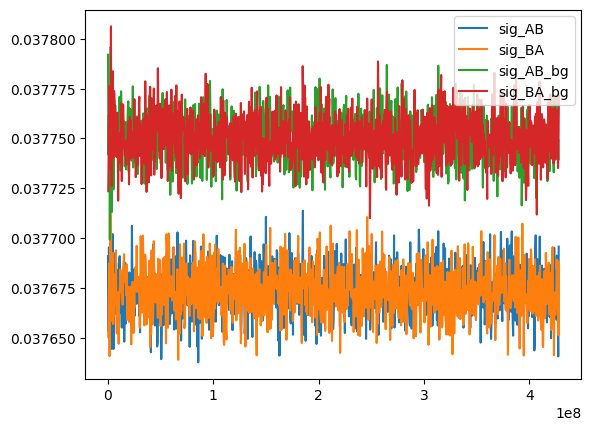

In [8]:
# import matplotlib.pyplot as plt
tau_AB = dataset["tau_AB"]
tau_BA = dataset["tau_BA"]
sig_AB = dataset["sig_AB"]
sig_AB_bg = dataset["sig_AB_bg"]
sig_BA = dataset["sig_BA"]
sig_BA_bg = dataset["sig_BA_bg"]
plt.plot(tau_AB, dataset["sig_AB"], label="sig_AB")
plt.plot(tau_BA, dataset["sig_BA"], label="sig_BA")
plt.plot(tau_AB, dataset["sig_AB_bg"], label="sig_AB_bg")
plt.plot(tau_BA, dataset["sig_BA_bg"], label="sig_BA_bg")
plt.legend()
plt.show()


In [9]:
# --- Define a helper function for FFT calculation ---
def calculate_fft(signal_avg, tau_array):
    N = len(signal_avg)
    try:
        T = tau_array[1] - tau_array[0]  # Sample spacing
    except IndexError:
        print("Warning: tau_array might not have enough points to determine sample spacing. Assuming T=1.")
        T = 1.0  # Default to 1 if not enough points

    # Remove DC component (mean) before FFT
    yf = np.fft.fft(signal_avg - np.mean(signal_avg))
    xf = np.fft.fftfreq(N, T)[:N//2] * 1e9

    # Amplitude normalization
    amplitude = 2.0/N * np.abs(yf[0:N//2])
    return xf, amplitude

# Calculate FFT for both signals
xf_AB, amp_AB = calculate_fft(sig_AB, dataset["tau_AB"])
xf_BA, amp_BA = calculate_fft(sig_BA, dataset["tau_BA"])
xf_AB, amp_AB_bg = calculate_fft(sig_AB_bg, dataset["tau_AB"])
xf_BA, amp_BA_bg = calculate_fft(sig_BA_bg, dataset["tau_BA"])
xf_AB, amp_AB_df = calculate_fft(sig_AB-sig_AB_bg, dataset["tau_AB"])
xf_BA, amp_BA_df = calculate_fft(sig_BA-sig_BA_bg, dataset["tau_BA"])


# --- Plotting with Plotly ---
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# Create subplots for time domain and frequency domain
fig = make_subplots(rows=1, cols=1,
                    subplot_titles=('Averaged Signals (Time Domain)', 'FFT of Averaged Signals (Frequency Domain)'))



# Add frequency domain plots
fig.add_trace(go.Scatter(x=xf_AB, y=amp_AB, mode='lines', name='FFT of sig_AB'),
              row=1, col=1)
fig.add_trace(go.Scatter(x=xf_BA, y=amp_BA, mode='lines', name='FFT of sig_BA'),
              row=1, col=1)
fig.add_trace(go.Scatter(x=xf_AB, y=amp_AB_bg, mode='lines', name='FFT of bg sig_AB'),
              row=1, col=1)
fig.add_trace(go.Scatter(x=xf_BA, y=amp_BA_bg, mode='lines', name='FFT of bg sig_BA'),
              row=1, col=1)
fig.add_trace(go.Scatter(x=xf_AB, y=np.abs(amp_AB-amp_AB_bg), mode='lines', name='FFT of sig_AB_df'),
              row=1, col=1)
fig.add_trace(go.Scatter(x=xf_BA, y=np.abs(amp_BA-amp_BA_bg), mode='lines', name='FFT of sig_BA_df'),
              row=1, col=1)


# Update layout for frequency domain plot
fig.update_xaxes(title_text='Frequency (Hz)', row=1, col=1) # Changed to MHz

fig.update_yaxes(title_text='Amplitude', row=1, col=1)

# Update overall layout
fig.update_layout(width=800, showlegend=True, hovermode="x unified")
fig.show()